In [1]:
import numpy as np
import pandas as pd
import pickle
import xgboost
import time
import gc
import lightgbm as lgb
from xgboost.sklearn import XGBClassifier
#warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score,\
roc_auc_score, f1_score, confusion_matrix, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from collections import Counter, defaultdict
from random import choice
from sklearn.model_selection import train_test_split

/anaconda3/envs/ml/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### Loading Data

In [2]:
# sessions
with open ("/Users/nanlin/msds/Adv_ML/leanplum/data/LeanPlum/session.pkl", "rb") as f:
    sessions = pickle.load(f)
    
# event
with open ("/Users/nanlin/msds/Adv_ML/leanplum/data/LeanPlum/events.pkl", "rb") as f:
    events = pickle.load(f)
    
# attribute 
with open ("/Users/nanlin/msds/Adv_ML/leanplum/data/LeanPlum/attr.pkl", "rb") as f:
    attr = pickle.load(f)

In [3]:
sessions.head()

,session_id,start_timestamp,timezone,timezone_offset,previous_sessions_duration,user_created_timestamp,is_user_first_session,country,region,city,latitude,longitude,locale,os_name,session_index,device_id,user_id_hash
0,5558845121177764917,1542215364580,Asia/Manila,28800000.0,25837591,1538874289458,False,PH,00,makati,14.554729,121.024445,en_GB,Android OS,30,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...
1,18781111175537580,1539215568666,Asia/Manila,28800000.0,11343848,1538874289458,False,PH,00,makati,14.554729,121.024445,en_GB,Android OS,10,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...
2,1477540082628742048,1540120743010,Asia/Manila,28800000.0,13499724,1538874289458,False,PH,11,davao city,7.190708,125.455338,en_GB,Android OS,13,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...
3,8184875317380844086,1542671625528,Asia/Manila,28800000.0,32788010,1538874289458,False,PH,00,makati,14.554729,121.024445,en_GB,Android OS,41,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...
4,4706180700083856343,1538997913013,Asia/Manila,28800000.0,5872534,1538874289458,False,PH,11,davao city,7.190708,125.455338,en_GB,Android OS,4,546a3d98-d540-4e72-ad82-9ebd64e0839b,9943447915df3a45fd6720a026af905b6da6b56a37701b...


In [4]:
events.head()

,session_id,event,event_timestamp,event_value,user_id_hash
0,5558845121177764917,45,1542215397132,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
1,5558845121177764917,45,1542215484895,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
2,7689508378645584666,.m5100869650219008,1541124410372,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
3,2201961907282901522,4,1543713091129,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
4,2201961907282901522,6,1543713093116,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...


### Data Preprocessing

In [ ]:
### create labels from Dec1 to Dec7 and Dec1 to Dec14 for training
## Combines all users: from attr and from sessions

In [5]:
users_attr = list(attr.user_id_hash.unique())
users_event = list(events.user_id_hash.unique())

users = pd.DataFrame(list(set(users_attr ) | set(users_event)),columns=['user_id_hash'])

In [6]:
users.head()

,user_id_hash
0,5b453da947f53fabf0053159dc246a9614f43c5ae00c71...
1,56b8d474bf7db8253c127f98fb95887d79ff660a13f1ed...
2,11d1f93d1fae9bf5c42c2bc83fe0e6c41a99512bfffdd2...
3,456847ce04bd6b20ce9b246fbd02fbd3915ab2b4aeac1f...
4,3aa523f08556310b44a4922aaf37e532cee367e0955b3d...


In [7]:
# first training label: Dec1 - Dec7
dec_event = events[(events["event_timestamp"] >= 1543651199000) & 
                  (events["event_timestamp"] < 1544255999000)]
puser1 = set(dec_event[dec_event["event"] == "8"].user_id_hash.unique())

# for training, the users include all unique users
users_train = users

labels1 = []
for user in list(users.user_id_hash.unique()):
    if user in puser1:
        labels1.append(1)
    else:
        labels1.append(0)
# label and add to train
users_train["purchased1"] = pd.DataFrame(labels1)

In [8]:
# second training label: Dec1-Dec14
dec2_event = events[(events["event_timestamp"] >= 1543651199000)]
puser2 = set(dec2_event[dec2_event["event"] == "8"].user_id_hash.unique())

labels2 = []
for user in list(users.user_id_hash.unique()):
    if user in puser2:
        labels2.append(1)
    else:
        labels2.append(0)

users_train["purchased2"] = pd.DataFrame(labels2)

In [9]:
attr.head()

,user_id_hash,session_id,attr_0,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,...,attr_19,attr_20,attr_22,attr_23,attr_24,attr_25,attr_26,attr_27,attr_28,attr_29
0,002e447aed33ed4c51a68743cc293ef2148058b6a6239e...,2662933751290886254,NaN,NaN,NaN,0.029999,romance_the_royal_romance_01:3,3.0,romance_the_royal_romance_01:3,NaN,...,NaN,None,None,None,NaN,2.0,NaN,2.0,NaN,NaN
1,002e447aed33ed4c51a68743cc293ef2148058b6a6239e...,5793726669394503241,NaN,NaN,NaN,0.000000,romance_the_royal_romance_01:2,2.0,romance_the_royal_romance_01:2,NaN,...,1.0,None,None,None,NaN,0.0,NaN,0.0,NaN,NaN
2,002e447aed33ed4c51a68743cc293ef2148058b6a6239e...,6545122651035219326,0.0,0.0,0.0,0.059998,romance_the_royal_romance_01:6,6.0,romance_the_royal_romance_01:6,1.0,...,0.0,picker ya_romance_vampire,NaN,None,0.0,5.0,0.0,5.0,1.0,NaN
3,0061b4d30e8a9935b2ebeec954ff509b4f0cb500cd725c...,2302333863698307661,0.0,0.0,0.0,0.000000,romance_rules_of_engagement_01:1,0.0,NaN,4.0,...,2.0,picker ya_romance_vampire,NaN,None,NaN,0.0,0.0,0.0,1.0,NaN
4,00fbbf507c7d3c2f259cd3329d241c29d35712e2d4699f...,215362132811035045,0.0,0.0,0.0,0.000000,romance_high_school_story_01:2,1.0,romance_high_school_story_01:1,1.0,...,1.0,picker ya_romance_vampire,NaN,None,NaN,0.0,0.0,0.0,1.0,NaN


### Generating Features

In [10]:
# before Dec 1, feature data sources: event, session, attributes
event_train = events[events["event_timestamp"] < 1543651199000]
session_train = sessions[sessions["start_timestamp"] < 1543651199000]
attr_train = attr

### Build separate rf to get important attributes

In [ ]:
# single rf to get the important features
attr_model = users_train.join(attr.set_index("user_id_hash"), on="user_id_hash", how="left")

In [ ]:
attr_model = attr_model.replace([np.inf, -np.inf], np.nan)
attr_model = attr_model.fillna(0)

In [234]:
rf_att = RandomForestClassifier(n_jobs=-1, n_estimators=1000, min_samples_leaf=50, max_depth=15, \
                            max_features=3, verbose=1)
rf_att.fit(X_train2, y_train2)
# predicting
score_val = rf_att.predict_proba(X_val2)[:,1]
score_train = rf_att.predict_proba(X_train2)[:,1]

print(f'auc score = {roc_auc_score(y_val2,score_val)}')
print(f'training auc = {roc_auc_score(y_train2,score_train)}')
print(f"Time use:{time.time()-t:.3f}s") 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 37.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   20.6s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:   26.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.1s


auc score = 0.8352070948299019
training auc = 0.8376178970474767
Time use:3638.733s


In [238]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train2.columns, rf_att.feature_importances_):
    feats[feature] = importance #add the name/value pair

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importance'})
importances.sort_values(['importance'],ascending=False)
#rf.feature_importances_

,importance
attr_14,0.356507
attr_1,0.173913
attr_13,0.142703
attr_8,0.076245
attr_17,0.053455
attr_5,0.047018
attr_2,0.029383
attr_3,0.019438
attr_16,0.018540
attr_25,0.015044


From the above feature importance, we got a sense of attributes' importance.
We decided on attr14, attr1, attr13, attr8, attr17, attr5 into our models

### Model 1 features

In [14]:
def features_model_l(val_raw,val_user,session_raw,att_raw,daycount,cut_time):
    
    # feature 1: event8 value mean
    eventvalue = val_raw[val_raw["event"]=="8"][["user_id_hash", "event_value"]].\
                groupby("user_id_hash").mean().reset_index()

    result = val_user.join(eventvalue.set_index("user_id_hash"), on="user_id_hash", how="left")
    
    #feature 2: purchase times
    purchase_times = val_raw[val_raw["event"]=="8"].groupby("user_id_hash")\
                    .size().reset_index(name='purchase_counts')
    purchase_times['purchase_counts'] = purchase_times['purchase_counts']/daycount
    result = result.join(purchase_times.set_index("user_id_hash"), on="user_id_hash", how="left")
    
    # feature 3: amount of event 5
    event5_value = val_raw[val_raw["event"]=="5"].groupby("user_id_hash")\
                    .size().reset_index(name='event5_count')
    event5_value['event5_count'] = event5_value['event5_count']/daycount
    result = result.join(event5_value.set_index("user_id_hash"), on="user_id_hash", how="left")
        
    # feature 4: avg previous session
    session_sum = session_raw.groupby("user_id_hash")["previous_sessions_duration"].\
    agg(['sum','mean']).reset_index()
    session_sum[['sum','mean']] = session_sum[['sum','mean']]/daycount
    result = result.join(session_sum[['user_id_hash','sum','mean']].set_index("user_id_hash"),\
                         on="user_id_hash", how="left")
    result = result.fillna(0)
    
    # feature 6: time diff from last event    

    first_last = val_raw.groupby("user_id_hash")['event_timestamp'].agg(['median','last']).reset_index()
    first_last['median_diff'] = cut_time - first_last['median']
    first_last['last_diff'] = cut_time - first_last['last']
    #first_last['user_id_hash'] = first_last['user_id_hash'].astype(str)
    first_last['median_diff']  = first_last['median_diff'].fillna(first_last['median_diff'].max())
    first_last['last_diff']  = first_last['last_diff'].fillna(first_last['last_diff'].max())
    #first_last['median_diff'] = first_last['median_diff']
    result = result.join(first_last[['user_id_hash','last_diff','median_diff']].set_index('user_id_hash'),\
                         on="user_id_hash", how="left")    
    
    att_raw_sum = att_raw[['user_id_hash','attr_14','attr_1','attr_13','attr_8','attr_17','attr_5']].groupby(['user_id_hash']).mean().reset_index()
    att_raw_sum[['attr_14','attr_1','attr_13','attr_8','attr_17','attr_5']] = \
    att_raw_sum[['attr_14','attr_1','attr_13','attr_8','attr_17','attr_5']]/daycount
    result = result.join(att_raw_sum[['user_id_hash','attr_14','attr_1','attr_13','attr_8','attr_17','attr_5']].\
                               set_index("user_id_hash"), on="user_id_hash", how="left")
    
    att_raw_count = att_raw[['user_id_hash','attr_14','attr_1','attr_13','attr_8','attr_17','attr_5']].groupby(['user_id_hash']).count().reset_index()
    att_raw_count[['attr_14_c','attr_1_c','attr_13_c','attr_8_c','attr_17_c','attr_5_c']] = \
    att_raw_count[['attr_14','attr_1','attr_13','attr_8','attr_17','attr_5']]/daycount
    result = result.join(att_raw_count[['user_id_hash','attr_14_c','attr_1_c','attr_13_c','attr_8_c','attr_17_c','attr_5_c']].\
                               set_index("user_id_hash"), on="user_id_hash", how="left")
    
    # fill inf attributes with 0
    result = result.replace([np.inf, -np.inf], np.nan)
    result = result.fillna(0)
    
    return result

train_feature_m1 = features_model_l(event_train,users_train,session_train,attr_train,daycount=60,cut_time=1543651199000)

In [15]:
train_feature_m1.shape

(622688, 22)

### Model2 Features

In [16]:
def features_model_2(val_raw,val_user,session_raw,att_raw,daycount,cut_time):
    # cut_time
    # feature 1: event8 value mean
    # all event value
    eventvalue = val_raw[["user_id_hash", "event_value"]].\
                groupby("user_id_hash").mean().reset_index()
    eventvalue['event_value'] = eventvalue['event_value']/daycount
    result = val_user.join(eventvalue.set_index("user_id_hash"), on="user_id_hash", how="left")
    result = result.replace([np.inf, -np.inf], 0)
    
    #feature 2: purchase times
    purchase_times = val_raw[val_raw["event"]=="8"].groupby("user_id_hash")\
                    .size().reset_index(name='purchase_counts')
    purchase_times['purchase_counts'] = purchase_times['purchase_counts']/daycount
    result = result.join(purchase_times.set_index("user_id_hash"), on="user_id_hash", how="left")
    event0_count = val_raw[val_raw["event"]=="0"].groupby("user_id_hash")\
                    .size().reset_index(name='event0_count')
    event0_count['event0_count'] = event0_count['event0_count']/daycount
    result = result.join(event0_count.set_index("user_id_hash"), on="user_id_hash", how="left")
    
    event5_count = val_raw[val_raw["event"]=="5"].groupby("user_id_hash")\
                    .size().reset_index(name='event5_count')
    event5_count['event5_count'] = event5_count['event5_count']/daycount
    result = result.join(event5_count.set_index("user_id_hash"), on="user_id_hash", how="left")
    
    
    session_sum = session_raw.groupby("user_id_hash")["previous_sessions_duration"].\
    agg(['sum','mean']).reset_index()
    session_sum[['sum','mean']] = session_sum[['sum','mean']]/daycount
    result = result.join(session_sum[['user_id_hash','sum','mean']].set_index("user_id_hash"),\
                         on="user_id_hash", how="left")
    
    result = result.fillna(0)
    
    first_last = val_raw.groupby("user_id_hash")['event_timestamp'].agg(['median','last']).reset_index()
    first_last['median_diff'] = cut_time - first_last['median']
    first_last['last_diff'] = cut_time - first_last['last']
    #first_last['user_id_hash'] = first_last['user_id_hash'].astype(str)
    first_last['median_diff']  = first_last['median_diff'].fillna(first_last['median_diff'].max())
    first_last['last_diff']  = first_last['last_diff'].fillna(first_last['last_diff'].max())
    #first_last['median_diff'] = first_last['median_diff']
    result = result.join(first_last[['user_id_hash','last_diff','median_diff']].set_index('user_id_hash'),\
                         on="user_id_hash", how="left")
    
    att_raw = att_raw[['user_id_hash','attr_14','attr_1','attr_13','attr_8','attr_17']].groupby(['user_id_hash']).\
    mean().reset_index()
    att_raw[['attr_14','attr_1','attr_13','attr_8','attr_17']] = \
    att_raw[['attr_14','attr_1','attr_13','attr_8','attr_17']]/daycount
    result = result.join(att_raw[['user_id_hash','attr_14','attr_1','attr_13','attr_8','attr_17']].\
                               set_index("user_id_hash"), on="user_id_hash", how="left")
    
    att_raw_count = att_raw[['user_id_hash','attr_14','attr_1','attr_13','attr_8','attr_17']].groupby(['user_id_hash']).count().reset_index()
    att_raw_count[['attr_14_c','attr_1_c','attr_13_c','attr_8_c','attr_17_c']] = \
    att_raw_count[['attr_14','attr_1','attr_13','attr_8','attr_17']]/daycount
    result = result.join(att_raw_count[['user_id_hash','attr_14_c','attr_1_c','attr_13_c','attr_8_c','attr_17_c']].\
                               set_index("user_id_hash"), on="user_id_hash", how="left")
    

    result = result.replace([np.inf, -np.inf], np.nan)
    result = result.fillna(0)
    
    #result[['median_diff','last_diff']].apply(lambda x:x/3.6e+6)    
    # transfer to seconds
    #result[['last_diff','median_diff','mean_duration']] = \
    #result[['last_diff','median_diff','mean_duration']].apply(lambda x:x/1000)   
    return result

train_feature_m2 = features_model_2(event_train,users_train,session_train,attr_train,60,cut_time=1543651199000)

In [17]:
train_feature_m2.describe()

,purchased1,purchased2,event_value,purchase_counts,event0_count,event5_count,sum,mean,last_diff,median_diff,attr_14,attr_1,attr_13,attr_8,attr_17,attr_14_c,attr_1_c,attr_13_c,attr_8_c,attr_17_c
count,622688.000000,622688.000000,622688.000000,622688.000000,622688.000000,622688.000000,6.226880e+05,6.226880e+05,6.226880e+05,6.226880e+05,622688.000000,622688.0,622688.00000,622688.000000,622688.000000,622688.000000,622688.000000,622688.000000,622688.000000,622688.000000
mean,0.007363,0.009457,0.000000,0.006304,0.009898,0.117102,4.320600e+06,6.365353e+04,2.496292e+09,2.555305e+09,0.000000,0.0,0.00000,NaN,0.000000,0.016634,0.016634,0.016634,0.016634,0.016634
std,0.085493,0.096788,0.000000,0.051183,0.009531,0.300568,4.805726e+07,2.139428e+05,1.481931e+09,1.472852e+09,0.000000,0.0,0.00000,0.000000,0.000000,0.000739,0.000739,0.000739,0.000739,0.000739
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.016667,0.000000e+00,0.000000e+00,1.215574e+09,1.278129e+09,0.000000,0.0,0.00000,0.000000,0.000000,0.016667,0.016667,0.016667,0.016667,0.016667
50%,0.000000,0.000000,0.005554,0.000000,0.016667,0.033333,1.512525e+03,6.952729e+02,2.431028e+09,2.500597e+09,0.016663,0.0,0.00000,0.016663,0.016663,0.016667,0.016667,0.016667,0.016667,0.016667
75%,0.000000,0.000000,0.012062,0.000000,0.016667,0.083333,1.662706e+05,3.752267e+04,3.724009e+09,3.775977e+09,0.041656,0.0,0.00000,0.061920,0.061096,0.016667,0.016667,0.016667,0.016667,0.016667
max,1.000000,1.000000,1.866211,7.416667,0.533333,13.416667,1.117057e+10,1.379166e+07,5.273823e+09,5.273857e+09,22.765625,75.0,18.34375,74.250000,14.101562,0.016667,0.016667,0.016667,0.016667,0.016667


### Train Validation Split

In [18]:
## Split X1, y1
X1 = train_feature_m1[train_feature_m1.columns.difference(['purchased1','purchased2','user_id_hash'])]
y1 = train_feature_m1["purchased1"]
#y2 = train_feature_m1["purchase2"]
X_train1, X_val1, y_train1, y_val1 = train_test_split(X1, y1, test_size=0.2, random_state=None, stratify=y1)

In [19]:
## Split X2, y2
y2 = train_feature_m2["purchased2"]
X2 = train_feature_m2[train_feature_m2.columns.difference(['purchased1','purchased2','user_id_hash'])]
X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y2, test_size=0.2, random_state=None, stratify=y2)

In [ ]:
X_train2.describe()

### Random Search On Random Forest
take a while to run the random search, skip this step

In [ ]:
'''
base parameters we previously used:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=1000, min_samples_leaf=50, max_depth=15, \
                            max_features=3, verbose=1)
'''
n_iterations=20

print ("Random search start...")

for col in ['model1_7day','model2_14day']:
    print(f"* training {col} ")
    #y = target[col]
    roc_auc_mean = []
    dict_list = []
    
    for i in range(0, n_iterations):
   # increasing max_features, n_estimators would dramatically slower the training process
   # min_samples_leaf: small leaves will capture noise in the training dataset
   #  
        param_dist = {'bootstrap': choice([True, False]),
                      'max_depth': choice([10, 30, 50, 100, None]),
                      'min_samples_leaf': choice([50, 100, 150,500]),
                      'max_features': choice(['auto','log2',3, None]),
                      'n_estimators': choice([1000, 1200, 1600, 2000]),
                      'n_jobs':-1,'verbose':1,'random_state':420}
        roc_l = []

        # training
        if col == 'model1_7day':
            X_train = X_train1
            X_val = X_val1
            y_train = y_train1
            y_val = y_val1
        else: 
            X_train = X_train2
            X_val = X_val2
            y_train = y_train2
            y_val = y_val2
            
        rf_rs = RandomForestClassifier(**param_dist)
        rf_rs.fit(X_train,y_train)
        # predicting
        y_pred = np.round(rf_rs.predict_proba(X_val)[:,1],3)
        
        roc = roc_auc_score(y_val, y_pred)
        roc_l.append(roc)
        roc_array = np.asarray(roc_l)

        roc_auc_mean.append(roc_array.mean())
        dict_list.append(param_dist)
        gc.collect()
        
    results_pd = pd.DataFrame({"roc_auc_mean": roc_auc_mean,"parameters": dict_list})    
    results_pd.sort_values("roc_auc_mean", ascending = False, axis = 0, inplace = True)
    
    top_pd = results_pd.head(1)
    
    print(f"--> Best AUC:{top_pd.iloc[0,0]} using {top_pd.iloc[0,1]}")

In [20]:
# parameters get from random search:
param_m1 = {'bootstrap': False, 'max_depth': 30, 'max_features': 3, 'min_samples_leaf': 50, 'n_estimators': 1600,\
            'n_jobs': -1, 'verbose': 1, 'random_state':420}
 
param_m2 = {'bootstrap': False, 'max_depth': 30, 'max_features': 3, 'min_samples_leaf': 50, 'n_estimators': 2000, \
            'n_jobs': -1, 'verbose': 1,'random_state':420}

### Results for validation set-M1

In [21]:
#using the results from random search
t = time.time()
# Model1 for 7 days

rf = RandomForestClassifier(**param_m1)
rf.fit(X_train1, y_train1)
# predicting
score_val = rf.predict_proba(X_val1)[:,1]
score_train = rf.predict_proba(X_train1)[:,1]

print(f'auc score = {roc_auc_score(y_val1,score_val)}')
print(f'training auc = {roc_auc_score(y_train1,score_train)}')
print(f"Time use:{time.time()-t:.3f}s") 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  5.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 1600 out of 1600 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

auc score = 0.9973028778456672
training auc = 0.9980745407075847
Time use:327.248s


In [ ]:
# before add count mean
auc score = 0.9960166356774655
training auc = 0.9976376736411126
Time use:347.621s

In [22]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train1.columns, rf.feature_importances_):
    feats[feature] = importance #add the name/value pair

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importance'})
importances.sort_values(['importance'],ascending=False)
#rf.feature_importances_

,importance
attr_13_c,0.147087
median_diff,0.130624
attr_1_c,0.107348
last_diff,0.099879
attr_14_c,0.087171
attr_13,0.058686
purchase_counts,0.056641
attr_1,0.049700
sum,0.037492
attr_14,0.032114


#### Confusion Matrix

In [24]:
ypred1 = rf.predict(X_val1)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 1600 out of 1600 | elapsed:    3.9s finished


In [25]:
ypred1

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
import seaborn as sns

In [ ]:
mat = confusion_matrix(y_val1, ypred1)

In [36]:
mat

array([[123514,    107],
       [   505,    412]])

In [39]:
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[123514    107]
 [   505    412]]


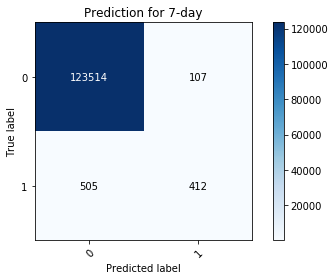

In [45]:
class_names = y_val1.unique()
plot_confusion_matrix(y_val1, ypred1,class_names,title='Prediction for 7-day')

### Results for validation set -M2

In [ ]:
# using the results from random search
#param = para_list_7days
t = time.time()
# Model1 for 14 days
rf2 = RandomForestClassifier(**param_m2)
rf2.fit(X_train2, y_train2)
# predicting
score_val = rf2.predict_proba(X_val2)[:,1]
score_train = rf2.predict_proba(X_train2)[:,1]

print(f'auc score = {roc_auc_score(y_val2,score_val)}')
print(f'training auc = {roc_auc_score(y_train2,score_train)}')
print(f"Time use:{time.time()-t:.3f}s") 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min


In [ ]:
# without count
auc score = 0.9966106836746187
training auc = 0.9978625216421286
Time use:456.094s

# with count
auc score = 0.9964504347979274
training auc = 0.9977199990424639
Time use:425.145s

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train2.columns, rf2.feature_importances_):
    feats[feature] = importance #add the name/value pair

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importance'})
importances.sort_values(['importance'],ascending=False)
#rf.feature_importances_

## Prediction on Test Data

In [326]:
sample = pd.read_csv("/Users/nanlin/msds/Adv_ML/leanplum/data/LeanPlum/sample_submission_2.csv")

In [430]:
attr.head()

,user_id_hash,session_id,attr_0,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,...,attr_19,attr_20,attr_22,attr_23,attr_24,attr_25,attr_26,attr_27,attr_28,attr_29
0,002e447aed33ed4c51a68743cc293ef2148058b6a6239e...,2662933751290886254,NaN,NaN,NaN,0.029999,romance_the_royal_romance_01:3,3.0,romance_the_royal_romance_01:3,NaN,...,NaN,None,None,None,NaN,2.0,NaN,2.0,NaN,NaN
1,002e447aed33ed4c51a68743cc293ef2148058b6a6239e...,5793726669394503241,NaN,NaN,NaN,0.000000,romance_the_royal_romance_01:2,2.0,romance_the_royal_romance_01:2,NaN,...,1.0,None,None,None,NaN,0.0,NaN,0.0,NaN,NaN
2,002e447aed33ed4c51a68743cc293ef2148058b6a6239e...,6545122651035219326,0.0,0.0,0.0,0.059998,romance_the_royal_romance_01:6,6.0,romance_the_royal_romance_01:6,1.0,...,0.0,picker ya_romance_vampire,NaN,None,0.0,5.0,0.0,5.0,1.0,NaN
3,0061b4d30e8a9935b2ebeec954ff509b4f0cb500cd725c...,2302333863698307661,0.0,0.0,0.0,0.000000,romance_rules_of_engagement_01:1,0.0,NaN,4.0,...,2.0,picker ya_romance_vampire,NaN,None,NaN,0.0,0.0,0.0,1.0,NaN
4,00fbbf507c7d3c2f259cd3329d241c29d35712e2d4699f...,215362132811035045,0.0,0.0,0.0,0.000000,romance_high_school_story_01:2,1.0,romance_high_school_story_01:1,1.0,...,1.0,picker ya_romance_vampire,NaN,None,NaN,0.0,0.0,0.0,1.0,NaN


In [486]:
# use all data for prediction
session_raw_test = sessions 
test_raw = events # all data
# add column name to user table
user_test = sample[['user_id_hash']]
attr_test = attr
# daycount = 75
test_feature_m1 = features_model_l(test_raw,user_test,session_raw_test,attr_test,\
                                   daycount=75,cut_time=1544860800000) # Dec 15
X_test_m1 = test_feature_m1[test_feature_m1.columns.difference(['purchased1','purchased2','user_id_hash'])]
X_test_m1.head()

,attr_1,attr_13,attr_13_c,attr_14,attr_14_c,attr_17,attr_17_c,attr_1_c,attr_5,attr_5_c,attr_8,attr_8_c,event5_count,event_value,last_diff,mean,median_diff,purchase_counts,sum
0,0.000000,0.000000,0.013333,0.000000,0.013333,0.006668,0.026667,0.013333,0.006668,0.026667,0.006668,0.026667,0.013333,0.0,4.247054e+09,4753.920000,4.247524e+09,0.0,9.507840e+03
1,0.266602,0.013336,0.013333,0.040009,0.013333,0.013336,0.013333,0.013333,0.066650,0.013333,0.066650,0.013333,0.040000,0.0,2.094650e+09,0.000000,2.096481e+09,0.0,0.000000e+00
2,0.000000,0.000000,0.013333,0.006668,0.026667,0.006668,0.026667,0.013333,0.006668,0.026667,0.006668,0.026667,0.013333,0.0,4.160548e+09,5181.750000,3.477653e+09,0.0,2.072700e+04
3,0.000000,0.000000,0.013333,0.046661,0.026667,0.093323,0.080000,0.013333,0.088928,0.080000,0.088928,0.080000,0.120000,0.0,4.287109e+09,122674.438667,4.288836e+09,0.0,1.226744e+06
4,0.000000,0.000000,0.013333,0.000000,0.013333,0.000000,0.013333,0.013333,0.000000,0.013333,0.000000,0.013333,0.000000,0.0,5.361336e+09,0.000000,5.535838e+09,0.0,0.000000e+00


In [487]:
# val_raw,val_user,session_raw,att_raw,daycount,cut_time
test_feature_m2 = features_model_2(test_raw,user_test,session_raw_test,attr_test,\
                                   daycount=75,cut_time=1544860800000) # Dec 15
X_test_m2 = test_feature_m2[test_feature_m2.columns.difference(['purchased1','purchased2','user_id_hash'])]
X_test_m2.head()

,attr_1,attr_13,attr_13_c,attr_14,attr_14_c,attr_17,attr_17_c,attr_1_c,attr_8,attr_8_c,event0_count,event5_count,event_value,last_diff,mean,median_diff,purchase_counts,sum
0,0.000000,0.000000,0.013333,0.000000,0.013333,0.006668,0.013333,0.013333,0.006668,0.013333,0.000000,0.013333,0.010254,4.247054e+09,4753.920000,4.247524e+09,0.0,9.507840e+03
1,0.266602,0.013336,0.013333,0.040009,0.013333,0.013336,0.013333,0.013333,0.066650,0.013333,0.013333,0.040000,0.005066,2.094650e+09,0.000000,2.096481e+09,0.0,0.000000e+00
2,0.000000,0.000000,0.013333,0.006668,0.013333,0.006668,0.013333,0.013333,0.006668,0.013333,0.013333,0.013333,0.011612,4.160548e+09,5181.750000,3.477653e+09,0.0,2.072700e+04
3,0.000000,0.000000,0.013333,0.046661,0.013333,0.093323,0.013333,0.013333,0.088928,0.013333,0.000000,0.120000,0.005539,4.287109e+09,122674.438667,4.288836e+09,0.0,1.226744e+06
4,0.000000,0.000000,0.013333,0.000000,0.013333,0.000000,0.013333,0.013333,0.000000,0.013333,0.013333,0.000000,0.000000,5.361336e+09,0.000000,5.535838e+09,0.0,0.000000e+00


In [488]:
# get rf, rf2
pred_1 = rf.predict_proba(X_test_m1)
pred_2 = rf2.predict_proba(X_test_m2)

test_feature_m1["user_purchase_binary_7_days"] = pd.DataFrame(pred_1[:,-1])
test_feature_m1["user_purchase_binary_14_days"] = pd.DataFrame(pred_2[:,-1])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 1600 out of 1600 | elapsed:    9.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:   13.6s finished


In [489]:
sub = sample[['user_id_hash']].merge(test_feature_m1[['user_id_hash','user_purchase_binary_7_days',\
                                             'user_purchase_binary_14_days']],on='user_id_hash',\
                               how='left')

In [491]:
# for users do not have previous data(including events,attributes and sessions), mark as 0
sub = sub.fillna(0)

In [492]:
sub.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days
0,e469dfaed039ead9110165d9bc457acb11609ca34057dc...,6.227370e-07,0.000015
1,afcc639a324b6c598ef83d360450afa011cb2dd1358bf9...,6.180467e-03,0.073235
2,fd5a7cf211d08e3e00f7be6a9df6e6ea3d2e5c22a5d9c3...,1.282677e-06,0.000013
3,00bfff98b9d0329f014c2eeac7ce47cd18b2bc6e10d608...,0.000000e+00,0.000116
4,0d298f3638c43e915c119d4935e1ce8d168f81b5e3e8c1...,1.039338e-04,0.000347


In [478]:
sub.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days
0,e469dfaed039ead9110165d9bc457acb11609ca34057dc...,6.227370e-07,8.651195e-07
1,afcc639a324b6c598ef83d360450afa011cb2dd1358bf9...,6.180467e-03,7.773798e-02
2,fd5a7cf211d08e3e00f7be6a9df6e6ea3d2e5c22a5d9c3...,1.282677e-06,1.500682e-08
3,00bfff98b9d0329f014c2eeac7ce47cd18b2bc6e10d608...,0.000000e+00,6.007653e-05
4,0d298f3638c43e915c119d4935e1ce8d168f81b5e3e8c1...,1.039338e-04,1.437932e-04


In [439]:
sub.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days
0,e469dfaed039ead9110165d9bc457acb11609ca34057dc...,5.479891e-07,1.026312e-06
1,afcc639a324b6c598ef83d360450afa011cb2dd1358bf9...,5.926877e-02,7.281958e-02
2,fd5a7cf211d08e3e00f7be6a9df6e6ea3d2e5c22a5d9c3...,8.160976e-07,1.384071e-08
3,00bfff98b9d0329f014c2eeac7ce47cd18b2bc6e10d608...,6.798865e-06,3.070213e-07
4,0d298f3638c43e915c119d4935e1ce8d168f81b5e3e8c1...,1.865140e-05,1.520545e-05


In [493]:
sub.to_csv("/Users/nanlin/msds/Adv_ML/leanplum/data/LeanPlum/submission_lastl", index=False)